In [2]:
# librerie utili
import os
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import collections
from tqdm import tqdm
import joblib 

In [3]:
# riproducibilità
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# configurazione
image_size = 224 # dimensione a cui ridimensionare ogni immagine
batch_size = 32  # batch size per i DataLoader
n_components = 323 # componenti principali che spiegano il 75% della varianza
noise_std = 0.2
train_ratio, val_ratio = 0.7, 0.15  # percentuali per suddividere in train/val/test

pretty_labels = ['adenocarcinoma', 'beigno', 'carcinoma squamoso']  # nome delle classi più leggibili

In [5]:
# percorsi utili
base_dir = os.getcwd()  # percorso base
data_dir = os.path.join(base_dir, 'data_histo') # percorso dataset
# percorso per salvare output
output_folder = os.path.join(base_dir, "pca_outputs")
os.makedirs(output_folder, exist_ok=True) # crea se non esiste
save_path = os.path.join(output_folder, f'pca_data_{n_components}_{noise_std}.pth')
pca_model_path = os.path.join(output_folder, f'pca_model_{n_components}_{noise_std}.pkl') 

In [5]:
# trasformazioni base (usate per val/test)
transform_base = transforms.Compose([
    transforms.Resize((image_size, image_size)), # ridimensiona le immagini
    transforms.ToTensor() # converte in tensore
])

In [6]:
# caricamento e split
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_base)  # carica tutte le immagini con le etichette
total_size = len(full_dataset)                                           # numero totale di immagini
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size                           # il resto va al test set

# suddivisione casuale ma riproducibile
train_indices, val_indices, test_indices = random_split(
    list(range(total_size)), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
train_subset = Subset(full_dataset, train_indices) # nuovi dataset (subset) contententi solo gli indici selezionati
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False) # creazione data loader per val e test
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [8]:
# caricamento dati augmentati (vedi file augmented_data.ipynb)
aug_data = torch.load(os.path.join("shared_augmented_data", f"augmented_train_data_{noise_std}.pt"))
train_imgs = aug_data['images']
train_labels = aug_data['labels']

# flatten immagini in vettori 1D
train_data = train_imgs.view(train_imgs.size(0), -1).numpy()

In [9]:
# estrazione e flattening di val e test
def extract_data(loader):
    data, labels = [], []
    for images, targets in tqdm(loader, desc="Estrazione dati"):
        flat = images.view(images.size(0), -1)
        data.append(flat)
        labels.append(targets)
    data = torch.cat(data, dim=0).numpy()
    labels = torch.cat(labels).numpy()
    return data, labels

val_data, val_labels = extract_data(val_loader)
test_data, test_labels = extract_data(test_loader)

Estrazione dati: 100%|██████████| 71/71 [00:52<00:00,  1.36it/s]


In [10]:
# normalizzazione (Z-SCORE)
# la normalizzazione viene effettuata utilizzando la media e la deviazione standard 
# calcolate solo sul set di training. Questo è fondamentale per evitare data leakage: 
# usare informazioni statistiche dai dati di validazione o test potrebbe introdurre bias
# e compromettere la validità della valutazione del modello.
mean = train_data.mean(axis=0)
std = train_data.std(axis=0) + 1e-8  # evita divisione per zero

def zscore(data):
    return (data - mean) / std

train_data = zscore(train_data)
val_data = zscore(val_data)
test_data = zscore(test_data)

In [11]:
# PCA
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(train_data) # fit su train
val_pca = pca.transform(val_data)          # transform su val
test_pca = pca.transform(test_data)        # transform su test

In [ ]:
# salvataggio
torch.save({
    'train_data': train_pca,
    'val_data': val_pca,
    'test_data': test_pca,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels,
    'class_names': pretty_labels
}, save_path)

# salvataggio PCA model (per ricostruzione immagini eventualmente)
joblib.dump(pca, pca_model_path)  
print(f"Dati PCA salvati in: {save_path}")
print(f"Modello PCA salvato in: {pca_model_path}")

Dati PCA salvati in: c:\Users\noemi\Documents\GitHub\PCA_AE_histology\pca_outputs\pca_data_323_0.2.pth
Modello PCA salvato in: c:\Users\noemi\Documents\GitHub\PCA_AE_histology\pca_outputs\pca_model_323_0.2.pkl


In [11]:
aug_data = torch.load("shared_augmented_data/augmented_train_data_0.2.pt")
train_imgs = aug_data['images']
train_data = train_imgs.view(train_imgs.size(0), -1).numpy()
mean = train_data.mean(axis=0)
std = train_data.std(axis=0) + 1e-8  # per sicurezza numerica


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20409796..1.092707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13231969..1.0884926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.024610966..1.2273891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0756363..1.1106889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06696886..1.037091].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16723987..1.0657121].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20629802.

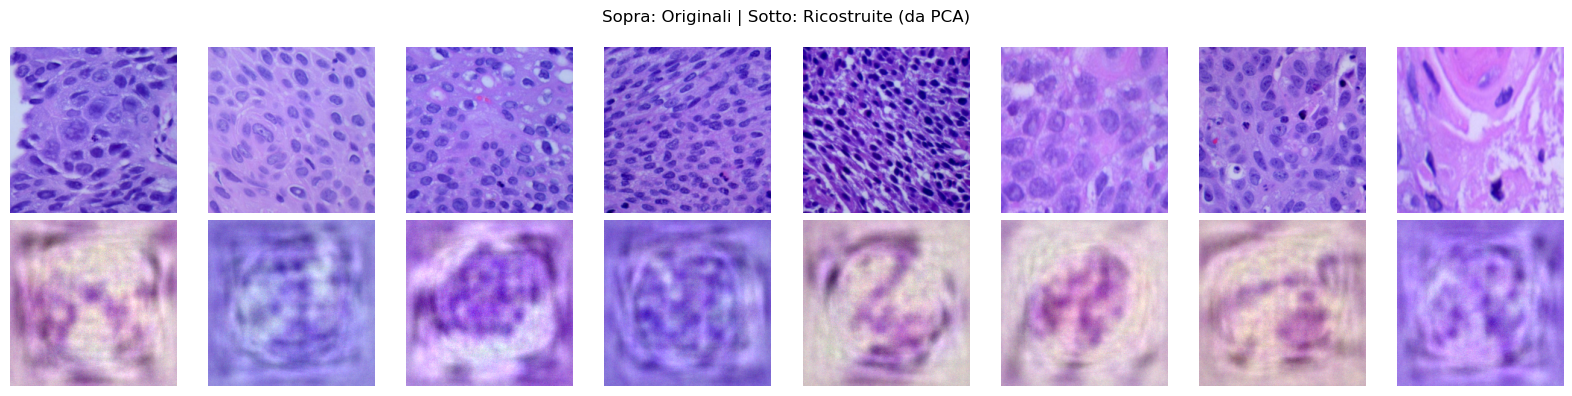

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from sklearn.decomposition import PCA
import joblib
import os

# --- Parametri
image_size = 224
noise_std = 0.2
n_components = 323

# --- Percorsi
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data_histo')
pca_model_path = os.path.join(base_dir, "pca_outputs", f"pca_model_{n_components}_{noise_std}.pkl")
pca_data_path = os.path.join(base_dir, "pca_outputs", f'pca_data_{n_components}_{noise_std}.pth')

# --- Caricamento dati compressi
pca = joblib.load(pca_model_path)
data_pca = torch.load(pca_data_path, weights_only=False)
test_pca = data_pca['test_data']

# --- Ricostruzione da PCA
reconstructed = pca.inverse_transform(test_pca[:8])  # (8, 150528)

# --- Calcolo mean/std dal training set originale (per denormalizzazione)
aug_data = torch.load(f"shared_augmented_data/augmented_train_data_{noise_std}.pt")
train_data_raw = aug_data['images'].view(aug_data['images'].size(0), -1).numpy()
mean = train_data_raw.mean(axis=0)
std = train_data_raw.std(axis=0) + 1e-8

# --- Denormalizzazione
reconstructed = reconstructed * std + mean  # (8, 150528)
reconstructed_imgs = torch.tensor(reconstructed).view(-1, 3, 224, 224)

# --- Caricamento immagini originali test (senza data augmentation)
transform_base = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_base)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
test_start_idx = train_size + val_size
test_subset_imgs = [full_dataset[i][0] for i in range(test_start_idx, test_start_idx + 8)]
test_imgs_tensor = torch.stack(test_subset_imgs)  # (8, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20409796..1.092707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13231969..1.0884926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.024610966..1.2273891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0756363..1.1106889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06696886..1.037091].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16723987..1.0657121].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20629802.

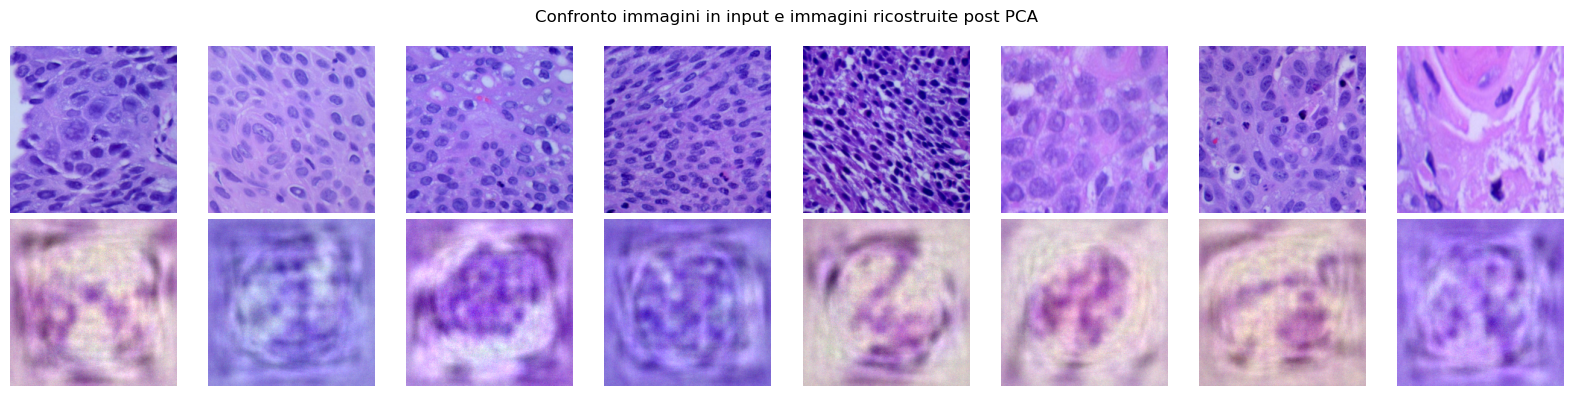

In [20]:
# plot confronto
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(test_imgs_tensor[i].permute(1, 2, 0).numpy())
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed_imgs[i].permute(1, 2, 0).numpy())
    axes[1, i].axis("off")

plt.suptitle("Confronto immagini in input e immagini ricostruite post PCA")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "reconstruction_examples.png"))
plt.show()